# Quick Start
Written by [Eliot Quon](mailto:eliot.quon@nrel.gov) -- 2017-01-03

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from samwich.dataloaders import PlanarData
from samwich.waketrackers import track

In [ ]:
# for inline animations
from IPython.display import HTML
#plt.rcParams['animation.html'] = 'html5'

List available wake trackers

In [4]:
track()

Need to specify 'method' as one of:
  Gaussian (samwich.gaussian.GaussianTracker)
  Gaussian2D (samwich.gaussian.Gaussian2DTracker)
  ConstantFlux (samwich.contour.ConstantFluxTracker)
  ConstantArea (samwich.contour.ConstantAreaTracker)
  CircularTestRegion (samwich.testregion.CircularTestRegionTracker)


['Gaussian',
 'Gaussian2D',
 'ConstantFlux',
 'ConstantArea',
 'CircularTestRegion']

## Case-specific parameters

In [5]:
D = 27.0  # to define the search range, and the reference area for the contour methods
zhub = 32.1  # hub height [m], for estimating the freestream reference velocity
refInduction = 0.3  # for estimating the momentum theory mass/momentum flux

## Read in test data
Note: General dataloaders exist to handle multiple sampling locations and/or many samples over time.

In [6]:
sample = {}
kinds = ['instantaneous','mean']
varlist = ['x','y','z','u','v','w']
for kind in kinds:
    sample[kind] = PlanarData({v: np.loadtxt(f'MWE-data/3D_{kind}_{v}_WFoR.txt') for v in varlist})
sample

{'instantaneous': Vector data array with shape (1,191,139) at 1 times,
 'mean': Vector data array with shape (1,191,139) at 1 times}

In [4]:
sample['mean']

Vector data array with shape (1,191,139) at 1 times

In [19]:
for kind in kinds:
    txtdata = {v: np.loadtxt(f'MWE-data/3D_{kind}_{v}_WFoR.txt') for v in varlist}
    np.savetxt(f'3D_{kind}_WFoR.csv',
               np.stack((txtdata[v].ravel() for v in varlist), axis=-1),
               fmt='%g',
               header=' '.join(varlist), delimiter=',')

/Users/equon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


In [7]:
txtdata = {v: np.loadtxt(f'MWE-data/freestream_mean_{v}_WFoR.txt') for v in varlist}
np.savetxt(f'freestream_WFoR.csv',
           np.stack((txtdata[v].ravel() for v in varlist), axis=-1),
           fmt='%g',
           header=' '.join(varlist), delimiter=',')

/Users/equon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


## Calculate freestream
Note: This is an optional step if upstream data are available.

In [5]:
data = {v: np.loadtxt(f'MWE-data/freestream_mean_{v}_WFoR.txt') for v in varlist}
free_z = data['z'][0,:]
free_Uprofile = np.mean(data['u'],axis=0)
jhub = np.argmin(np.abs(data['y'][:,0]-np.mean(data['y'][:,0])))
khub = np.argmin(np.abs(data['z'][0,:]-zhub))
ref_velocity = data['u'][jhub,khub]
free_const = free_Uprofile*0.0 + ref_velocity
print('ref velocity is',ref_velocity)

ref velocity is 6.66985855074


Text(0,0.5,'z (m)')

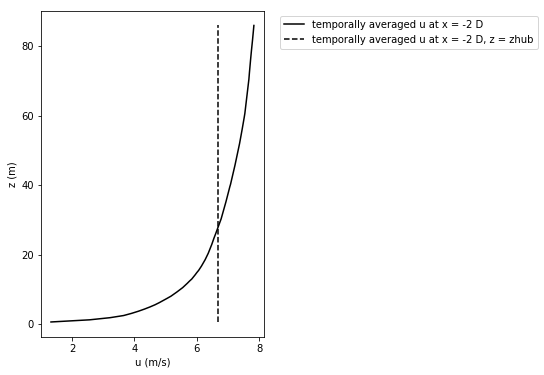

In [6]:
plt.figure(figsize=(4,6))
plt.plot(free_Uprofile,free_z,'-k',label='temporally averaged u at x = -2 D')
plt.plot(free_const,free_z,'--k',label='temporally averaged u at x = -2 D, z = zhub')
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.xlabel('u (m/s)')
plt.ylabel('z (m)')

## Create wake tracking objects

In [7]:
wake = { kind: track(sample[kind].sliceI(),
                     method='ConstantArea',
                     verbose=True) 
         for kind in kinds }

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: ConstantArea

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing contourwaketracker

...finished initializing ConstantArea 

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: ConstantArea

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketrac

Initializing plot
Initializing plot


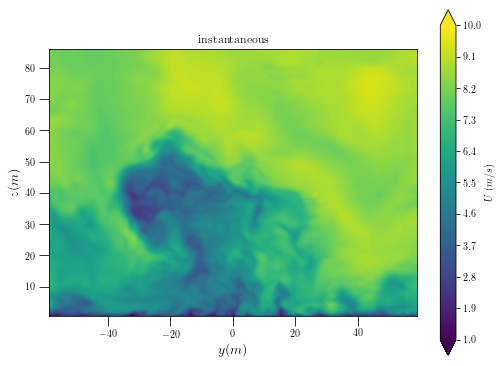

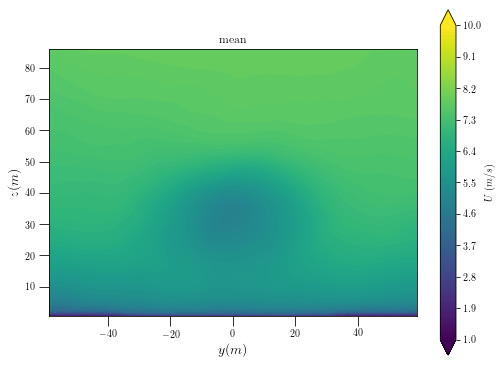

In [8]:
c1,c2 = 1.0, 10.
for iax,kind in enumerate(kinds):
    wake[kind].clear_plot()  # force replot for python notebook
    wake[kind].plot_contour(vmin=c1,vmax=c2)
    plt.title(kind)

## Remove shear
Note: This never works perfectly in practice.

  subtracting out constant profile
Initializing plot
  subtracting out constant profile
Initializing plot


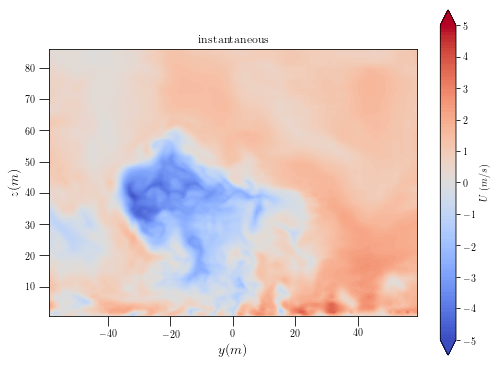

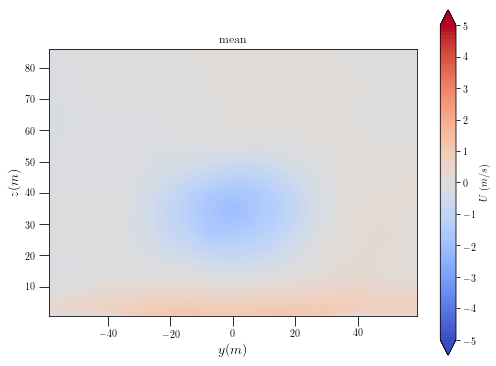

In [9]:
c1,c2 = -5,5
# input profile array should match wake.Nv (v: "vertical")
# otherwise interpolate to wake.z[0,:] locations first...
for kind in kinds:
    #wake[kind].remove_shear(wind_profile=free_const)
    wake[kind].remove_shear(wind_profile=free_Uprofile)
    wake[kind].clear_plot()  # force replot for python notebook
    wake[kind].plot_contour(vmin=c1,vmax=c2,cmap='coolwarm')
    plt.title(kind)

## Find the wake center

In [10]:
refArea = np.pi*D**2/4
yc,zc = {},{}
for kind in kinds:
    wake[kind].wake_tracked = False  # force recalculation for python notebook
    #yc[kind],zc[kind] = wake[kind].find_centers(refArea, weighted_center=False)  # geometric center
    #yc[kind],zc[kind] = wake[kind].find_centers(refArea, weighted_center=True)  # weighted by velocity deficit
    yc[kind],zc[kind] = wake[kind].find_centers(refArea, weighted_center=lambda u: u**2)  # specified weighting function

Attempting to match area: 572.5552611167398 m^2
Attempting to match area: 572.5552611167398 m^2


Processed frame 0
Processed frame 0


Initializing plot
Initializing plot


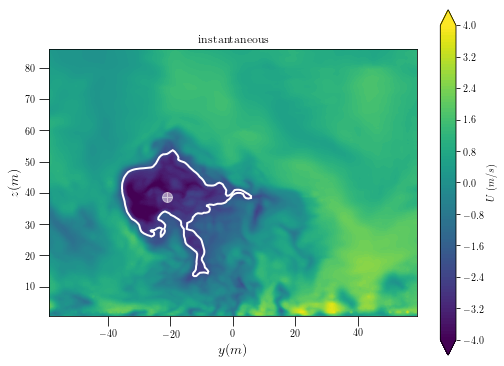

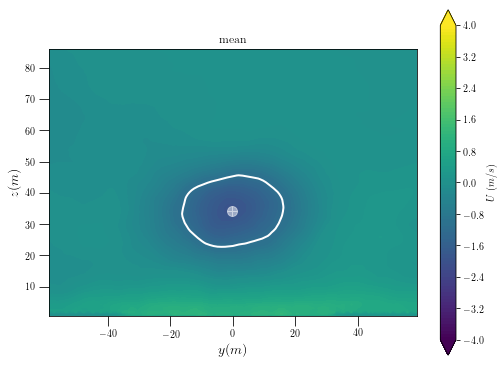

In [11]:
c1,c2 = -4,4
for kind in kinds:
    wake[kind].clear_plot()  # force replot for python notebook
    wake[kind].plot_contour(vmin=c1,vmax=c2,
                            outline=True)  # if the selected tracker detects/approximates the wake edge,
                                           # then let's plot it
    plt.title(kind)

In [12]:
for kind in kinds:
    print(kind,'center at',(yc[kind][0],zc[kind][0]))  # time "0"

instantaneous center at (-21.248987952586429, 38.606919353619801)
mean center at (-0.20481441784716278, 34.235607367980364)
